In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
from poldracklab.fmri.spm_hrf import spm_hrf
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# use data from both runs, concatenate them
def get_subdata(sub, verbose=False):
    sub = str(sub).zfill(2)
    events_df = None
    maxtime = None
    for run in [1,2]:
        eventfile = f'AHRB/sub-{sub}/ses-1/func/sub-{sub}_ses-1_task-mid_run-0{run}_events.tsv'
        df = pd.read_csv(eventfile, sep='\t')
        if verbose:
            print(f'Loading {eventfile}')
            print(df.shape)
        assert df.shape[1] > 2, f'bad parsing'
        if events_df is None:
            events_df = df
            maxtime = np.ceil(events_df['FEEDBACK_ONSET'].max() + events_df['FEEDBACK_DURATION'].values[-1])
        else:
            onset_cols = [col for col in df.columns if 'ONSET' in col]
            for col in onset_cols:
                df[col] += maxtime
            events_df = pd.concat([events_df, df])
    return events_df


def insert_jitter(events, miun_iti=4, max_iti=12):
    jitter = np.round(np.random.uniform(miun_iti, max_iti, events.shape[0]), 2)
    jitter[0] = 0
    cumulative_jitter = np.cumsum(jitter)
    events['jitter'] = jitter
    events['cumulative_jitter'] = cumulative_jitter
    onset_cols = [col for col in events.columns if 'ONSET' in col]
    for col in onset_cols:
        events[col] += cumulative_jitter
    return events


def make_stick_function(onsets, durations, length, resolution=.2):
    """
    Create a stick function with onsets and durations

    Parameters
    ----------
    onsets : list
        List of onset times
    durations : list
        List of duration times
    length : float
        Length of the stick function (in seconds)
    resolution : float
        Resolution of the stick function (in seconds)
        0.1 secs by default
    
    Returns
    -------
    sf : np.array
        Timepoints of the stick function
    """
    timepoints = np.arange(0, length, resolution)
    sf = np.zeros_like(timepoints)
    for onset, duration in zip(onsets, durations):
        sf[(timepoints >= onset) & (timepoints < onset + duration)] = 1
    sf_df = pd.DataFrame({'sf': sf})
    sf_df.index = timepoints
    return sf_df

def create_design_matrix(events_df, resolution=.2, hrf_length=32, verbose=False):
    # create the full design matrix
    maxtime = np.ceil(events_df['FEEDBACK_ONSET'].max() + events_df['FEEDBACK_DURATION'].values[-1])
    timepoints = np.arange(0, maxtime, resolution)
    if verbose:
        print(f'Maxtime: {maxtime}')
        print(f'Timepoints: {timepoints.shape}')
    event_classes = ['CUE', 'FIXATION', 'PROBE', 'FEEDBACK']
    trial_types = events_df.TRIAL_TYPE.unique().tolist()
    desmtx = pd.DataFrame()
    desmtx_conv = pd.DataFrame()
    for trial_type in trial_types:
        for event_class in event_classes:
            if verbose:
                print(f'Creating stick function for {event_class}')
            if event_class != 'FEEDBACK':
                events_trialtype = events_df[events_df.TRIAL_TYPE == trial_type]
                onsets = events_trialtype[f'{event_class}_ONSET'].values
                durations = events_trialtype[f'{event_class}_DURATION'].values
                sf_df = make_stick_function(onsets, durations, maxtime)
                desmtx[f'{event_class}_{trial_type}'] = sf_df.sf.values
                desmtx_conv[f'{event_class}_{trial_type}'] = np.convolve(sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
            else:
                for probe_class in [1, 0]:
                    probe_str = 'HIT_' if probe_class == 1 else 'MISS_'
                    events_trialtype = events_df[(events_df.TRIAL_TYPE == trial_type) & (events_df.PROBE_HIT == probe_class)]
                    onsets = events_trialtype[f'{event_class}_ONSET'].values
                    durations = events_trialtype[f'{event_class}_DURATION'].values
                    sf_df = make_stick_function(onsets, durations, maxtime)
                    desmtx[f'{event_class}_{probe_str}{trial_type}'] = sf_df.sf.values
                    desmtx_conv[f'{event_class}_{probe_str}{trial_type}'] = np.convolve(sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
    # add cue + fix for later models
    # clip at 1 to deal with overlapping cues and fixations
    #desmtx['CUE_FIX'] = np.clip(desmtx['CUE'].values + desmtx['FIXATION'].values, 0, 1)
    #desmtx_conv['CUE_FIX'] = np.convolve(desmtx['CUE_FIX'].values, spm_hrf(resolution))[:sf_df.shape[0]]
    desmtx.index = timepoints
    desmtx_conv.index = timepoints
    return desmtx, desmtx_conv



In [3]:
vifs_orig = []
vifs_jittered = []
verbose = False

subnums = []

for sub in range(1, 109):
    try:
        events = get_subdata(sub)
    except:
        if verbose:
            print(f'Error loading sub {sub}')
        continue
    subnums.append(sub)
    events_jittered = insert_jitter(events)
    desmtx, desmtx_conv  = create_design_matrix(events, resolution=0.2)
    desmtx_jittered, desmtx_conv_jittered  = create_design_matrix(events_jittered, resolution=0.2)
    vifs_orig.append([variance_inflation_factor(desmtx_conv.values, i) for i in range(desmtx_conv.shape[1])])
    vifs_jittered.append([variance_inflation_factor(desmtx_conv_jittered.values, i) for i in range(desmtx_conv_jittered.shape[1])])


In [9]:
def reorder_cols(df):
    conds = ['NoMoneyStake', 'LargeGain', 'SmallGain', 'LargeLoss', 'SmallLoss']
    regs = ['CUE', 'FIXATION', 'PROBE', 'FEEDBACK_HIT', 'FEEDBACK_MISS']
    newcols = []
    for reg in regs:
        for cond in conds:
            newcols.append(f'{reg}_{cond}')
    assert set(df.columns) == set(newcols), f'Columns do not match: {set(df.columns)} != {set(newcols)}'
    return df[newcols]

vifs_orig_df = reorder_cols(pd.DataFrame(vifs_orig, columns=desmtx_conv.columns))
vifs_orig_df['subject'] = subnums
vifs_orig_df = vifs_orig_df.melt(id_vars='subject', var_name='condition', value_name='VIF')

vifs_jittered_df = reorder_cols(pd.DataFrame(vifs_jittered, columns=desmtx_conv_jittered.columns))
vifs_jittered_df['subject'] = subnums
vifs_jittered_df = vifs_jittered_df.melt(id_vars='subject', var_name='condition', value_name='VIF')


Text(0.5, 0, 'Variance inflation factor')

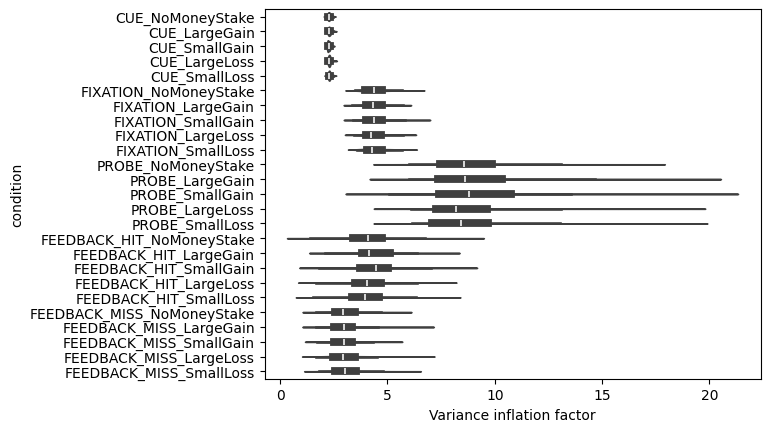

In [11]:
sns.violinplot(data=vifs_orig_df, y='condition', x='VIF')
plt.xlabel('Variance inflation factor')

In [6]:
desmtx_conv.columns

Index(['CUE_LargeLoss', 'FIXATION_LargeLoss', 'PROBE_LargeLoss',
       'FEEDBACK_HIT_LargeLoss', 'FEEDBACK_MISS_LargeLoss', 'CUE_NoMoneyStake',
       'FIXATION_NoMoneyStake', 'PROBE_NoMoneyStake',
       'FEEDBACK_HIT_NoMoneyStake', 'FEEDBACK_MISS_NoMoneyStake',
       'CUE_SmallLoss', 'FIXATION_SmallLoss', 'PROBE_SmallLoss',
       'FEEDBACK_HIT_SmallLoss', 'FEEDBACK_MISS_SmallLoss', 'CUE_LargeGain',
       'FIXATION_LargeGain', 'PROBE_LargeGain', 'FEEDBACK_HIT_LargeGain',
       'FEEDBACK_MISS_LargeGain', 'CUE_SmallGain', 'FIXATION_SmallGain',
       'PROBE_SmallGain', 'FEEDBACK_HIT_SmallGain', 'FEEDBACK_MISS_SmallGain'],
      dtype='object')